# Time Series Analysis

_The only thing we know about the future is that it will be different_ - Peter Drucker

Time series analysis is a fundamental statistical technique used to analyze data points collected over time. A time series can exhibit multiple components, such as long-term trends, cyclical fluctuations, seasonal variations, and irregular random movements. Understanding these components enables analysts to build accurate predictive models. We explore key concepts in time series analysis, including trend patterns, seasonality, stationarity, autocorrelation, and various statistical models such as autoregressive (AR), moving average (MA), and autoregressive moving average (ARMA) models. We also examine forecasting methods and statistical tests used to assess time series properties.



In [39]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error        
from finds.readers import Alfred
from secret import credentials
VERBOSE = 0
# %matplotlib qt

We retrieve the Industrial Production (IP) total index monthly time series from FRED.  

In [40]:
series_id, freq, start = 'IPB50001N', 'ME', 0  # not seasonally adjusted
alf = Alfred(api_key=credentials['fred']['api_key'])
df = alf(series_id, log=1, freq=freq, start=start).dropna()
date_title = f" ({df.index[0]//100}-{df.index[-1]//100})"
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df.index.freq = freq               # set index to datetime type with 'M frequency
alf.header(series_id)

'Industrial Production: Total Index'

## Seasonality

A time series can be broken down into three key components:

- **Trend** – Represents long-term movements in the data.
- **Seasonality** – Captures predictable and recurring changes within a specific time frame.
- **Cyclical** – Encompasses longer-term cycles that are influenced by broader economic or structural factors.

If a time series $Y_t$​ exhibits seasonality, its mean can differ across periods, repeating every $s$ periods (e.g., quarterly with $s=4$ or monthly with $s=12$). Deterministic seasonal effects can be effectively modeled using dummy variables.


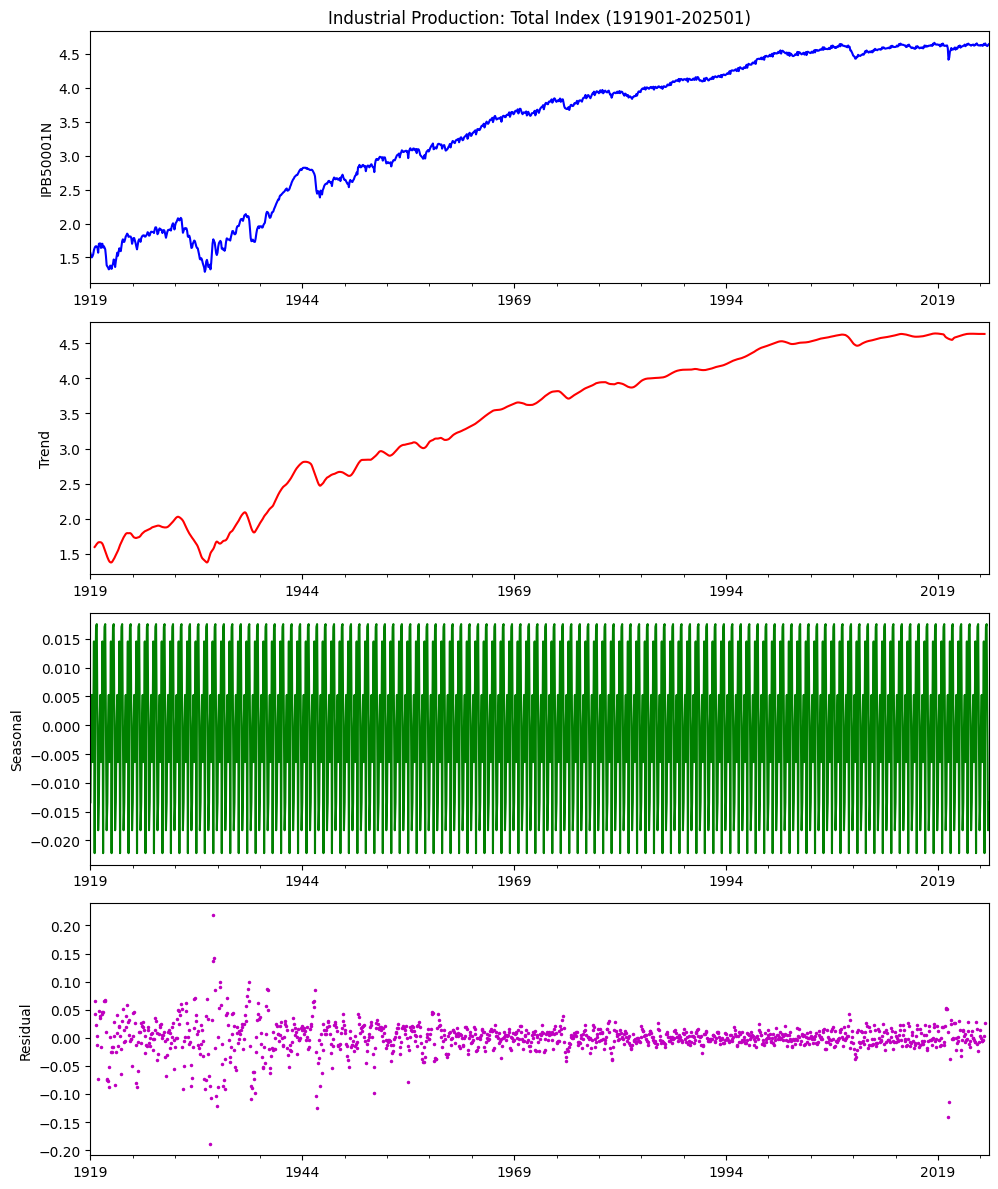

In [41]:
## Seasonality Decomposition Plot
result = seasonal_decompose(df, model='add')
fig, ax = plt.subplots(nrows=4, ncols=1, clear=True, figsize=(10, 12))
result.observed.plot(ax=ax[0], title=alf.header(result.observed.name) + date_title,
                     ylabel=result.observed.name, xlabel='', c='b')
result.trend.plot(ax=ax[1], ylabel='Trend', xlabel='', c='r')
result.seasonal.plot(ax=ax[2], ylabel='Seasonal', xlabel='', c='g')
result.resid.plot(ax=ax[3], ls='', ms=3, marker='.', c='m',
                  ylabel='Residual', xlabel='')
plt.tight_layout()

## Stationarity


A time series is considered **covariance-stationary** if it meets three key conditions:  
1. The mean remains constant over time, i.e., $ E[Y_t] = m $ for all $ t $.  
2. The variance is finite and does not change over time, i.e., $ V[Y_t] = \gamma_0 < \infty $.  
3. The autocovariance depends only on the time lag $ h $ and not on $ t $, i.e., $ Cov[Y_t, Y_{t-h}] = \gamma_h $.  

Covariance stationarity depends on the first two moments of a time series. Stationarity is crucial for modeling and forecasting because stationary series exhibit stable statistical properties. The **Augmented Dickey-Fuller (ADF) test** helps determine whether a time series has a unit root, with the null hypothesis stating that a unit root is present. If the p-value is below a critical threshold, the null hypothesis can be rejected, indicating stationarity.  

In [42]:
values = df.diff().dropna().values.squeeze()
adf = adfuller(values)
DataFrame.from_dict({"I(1)": list(adf[:4]) + list(adf[4].values())},
                    orient='index',
                    columns=(['Test Statistic', 'p-value', 'Lags Used', 'Obs Used'] +
                             [f"critical({k})" for k in adf[4].keys()])).round(3)

,Test Statistic,p-value,Lags Used,Obs Used,critical(1%),critical(5%),critical(10%)
I(1),-7.266,0.0,23,1248,-3.436,-2.864,-2.568


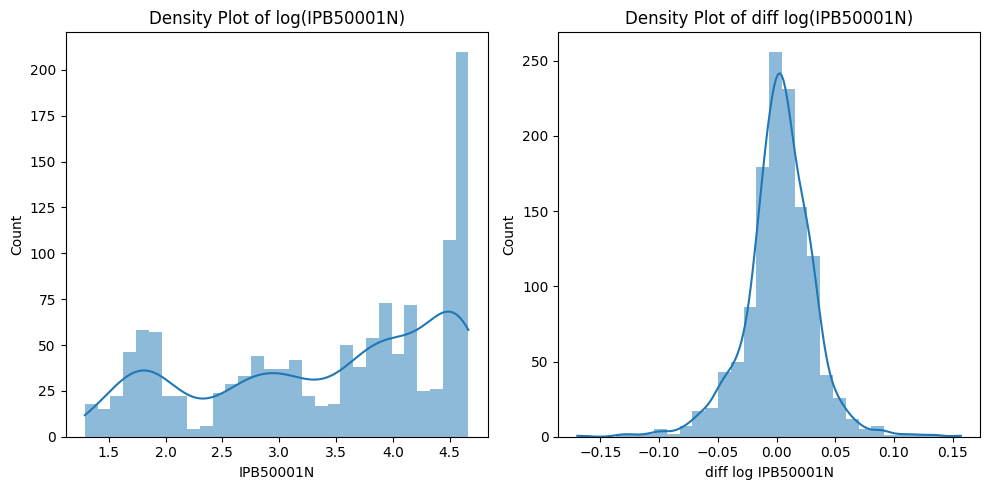

In [43]:
# Histogram Plot and Kernel Density Estimate
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
sns.histplot(df.dropna(), bins=30, lw=0, kde=True, ax=axes[0])
axes[0].set_title(f"Density Plot of log({series_id})")
sns.histplot(df.diff().dropna().rename(f"diff log {series_id}"),
             bins=30, lw=0, kde=True, ax=axes[1]) #line_kws={"color": "r"}
axes[1].set_title(f"Density Plot of diff log({series_id})")
plt.tight_layout()

## Autocorrelation 

Autocorrelation measures the relationship between time series observations at different points in time. The autocorrelation function (ACF) at lag $ h $ is given by:  
$$
\rho_h = \frac{\gamma_h}{\gamma_0}
$$  
where $ \gamma_h $ is the autocovariance at lag $ h $, and $ \gamma_0 $ is the variance.  

The **partial autocorrelation function (PACF)** isolates the direct relationship between observations separated by lag $ h $, removing the influence of intermediate lags (i.e., $Y_{t-1}, Y_{t-2}, ..., Y_{t-h+1}$).

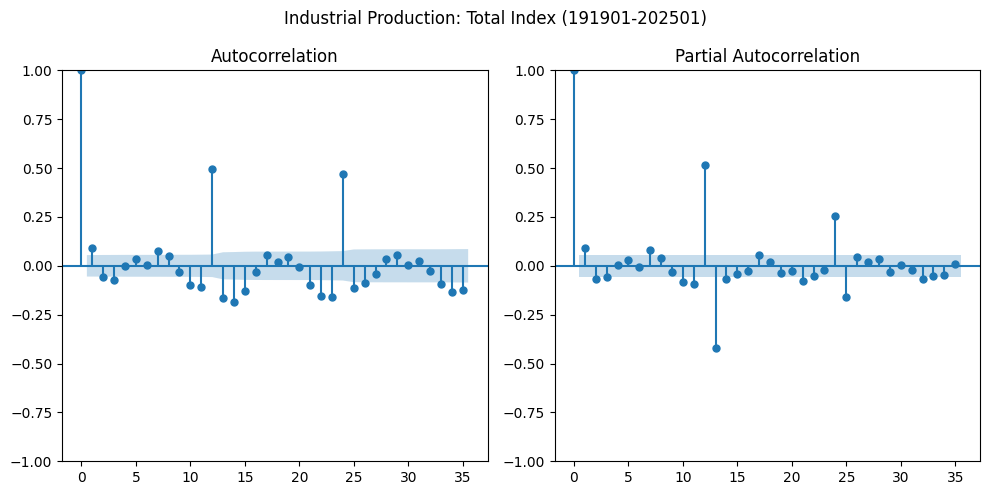

In [44]:
values = df.diff().dropna().values.squeeze()
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
plot_acf(values, lags=35, ax=axes[0])
plot_pacf(values, lags=35, ax=axes[1], method='ywm')
plt.suptitle(alf.header(result.observed.name) + date_title)
plt.tight_layout()

## Time Series Models


### Autoregressive (AR) models

Autoregressive (AR) models describe a time series in terms of its past values. An AR(1) process follows:  
$$
Y_t = \delta + \phi Y_{t-1} + \epsilon_t
$$  
where $ \delta $ is the intercept, $ \phi $ is the autoregressive coefficient, and $ \epsilon_t $ is white noise.  

For a higher-order AR(p) model:  
$$
Y_t = \mu + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \epsilon_t
$$  

The PACF for an AR process is nonzero only for the first $ p $ lags, while the ACF gradually decays ($\rho(h) = \phi^{|h|}$)



### Moving average (MA) models**  

A moving average model expresses $ Y_t $ as a function of past shocks:  
$$
Y_t = \mu + \theta_1 \epsilon_{t-1} + \epsilon_t
$$  
An MA(q) model extends this to include $ q $ lags of $ \epsilon $:
$$Y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$$

The ACF of an MA process is zero for lags greater than $ q $, while the PACF has a more complex structure.  



### ARMA models

An **ARMA(p, q)** model combines AR and MA components. For example, a simple ARMA(1,1) evolves according to: 
$$
Y_t = \mu + \phi Y_{t-1} + \theta \epsilon_{t-1} + \epsilon_t
$$  
- The mean of this process is $\mu = \delta / (1 - \phi)$
- The variance is $\gamma_0 = \sigma^2(1 + 2\phi \theta + \theta^2)/(1 - \phi^2)$


An ARMA(1,1) process is covariance-stationary if $|\phi| <> 1$. The MA coefficient plays no role in determining whether the process is covariance-stationary, because any MA is covariance-stationary as the MA component only affects a single lag of the shock. The AR component, however, affects all lagged shocks and so if $\phi_1$ is too large, then the time series is not covariance-stationary.



### Lag lengths

Determining the appropriate lag lengths for the AR and MA components (i.e., p and q, respectively) is a key challenge when building an ARMA model. The first step in model building is to inspect the sample autocorrelation and sample PACFs. 

The __Box-Pierce__ test statistic is the sum of the squared autocorrelations scaled by the sample size T: 
$$Q_{BP} = T\sum_{i=1}^h (\dfrac{T+1}{T-1}) \hat{\rho}_i^2$$

When the null is true, $Q_{BP}$ is asymptotically distributed as a $\chi_h^2$ variable.  

The __Ljung-Box__ statistic is a modified version of the Box-Pierce statistic that works better in smaller samples, and is defined as: 
$$Q_{LB} = T\sum_{i=1}^h (\dfrac{T+2}{T-i}) \hat{\rho}_i^2$$





### Seasonal component
Seasonal components can be added to the short-term components of an ARMA(p,q) model, by using lags only at the seasonal frequency.  A seasonal ARMA combines
these two components into a single specification: 

$$ARMA (p, q) \times (p_s, q_s)_f$$

where p and q are the orders of the short-run lag polynomials, $p_s$ and $q_s$ represent seasonal lag orders, and $f$ denotes the seasonal horizon (e.g., every 3 or 12 months with monthly observations).



### Unit Roots

Random walks are most important source of **non-stationarity** in economic time series. A simple random walk process evolves according to:

$$Y_t = Y_{t-1} + \epsilon_t$$ 

Unit roots generalize random walks by adding short-run stationary dynamics to the long-run random walk.

Spurious relationships can occur when non-stationary series are regressed against each other; this produces produces a coefficient estimate that is large and seemingly statistically different from zero when using conventional statistical distributions to obtain the critical values. 

Differencing removes unit roots and prevents such misleading results. If $Y_t$ has a unit root (i.e. has **integration order** equal to 1), then the difference: $\Delta Y_t = Y_t - Y_{t-1}$ does not.



### SARIMAX model

The **Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors (SARIMAX)** model is denoted:  
$$
(p, d, q) \times (P, D, Q)_s
$$  
where:  
- $ (p, d, q) $ are the orders of AR, differencing, and MA components.  
- $ (P, D, Q, s) $ are the seasonal counterparts and periodicity.


In [45]:
split_date = df.index[-12]   # train/test split date
# df_train = df.loc[:split_date].dropna()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09476D+00    |proj g|=  3.46166D-01

At iterate    5    f= -2.09484D+00    |proj g|=  2.67321D-02

At iterate   10    f= -2.09486D+00    |proj g|=  1.29274D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   8.413D-04  -2.095D+00
  F =  -2.0948681083990448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              IPB50001N   No. Observations:                 1273
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2666.767
Date:                Mon, 03 Mar 2025   AIC                          -5325.534
Time:                        10:54:09   BIC                          -5304.941
Sample:                    01-31-1919   HQIC                         -5317.799
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.001      2.396      0.017       0.000       0.005
ar.L1         -0.1167      0.223     -0.524      0.600      -0.553       0.320
ma.L1          0.2195      0.222      0.987      0.323      -0.216       0.655
sigma2         0.0009   2.21e-05     39.946      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               563.24
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

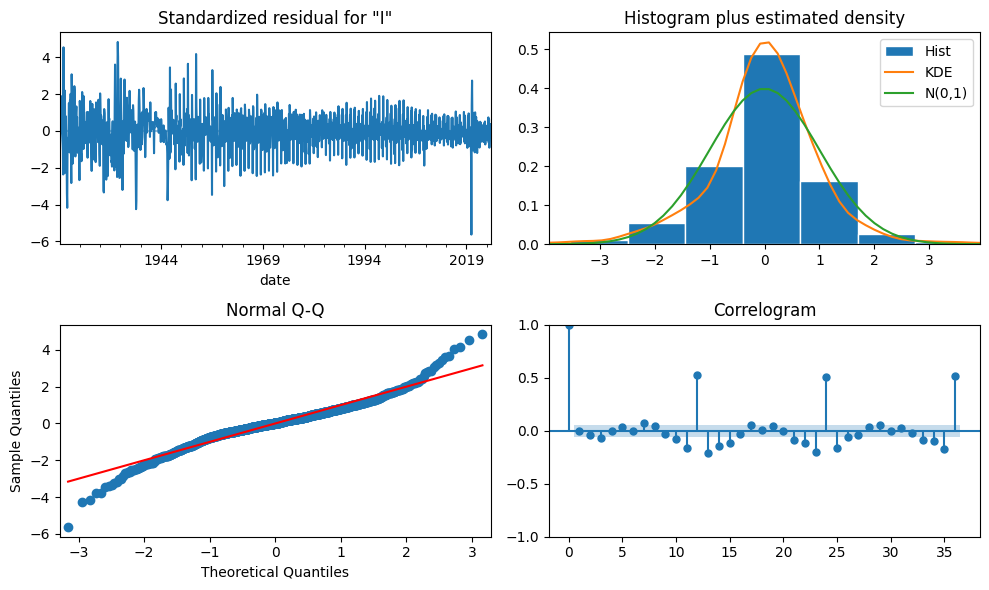

In [46]:
# Fit a SARIMA(1,1,3) with seasonal order (0, 0, 0, 12)
pdq = (1, 1, 1)   #(12, 1, 0)
seasonal_pdqs = (0, 0, 0, 12)
arima = SARIMAX(df, order=pdq, seasonal_order=seasonal_pdqs, trend='c').fit()
fig = arima.plot_diagnostics(figsize=(10, 6), lags=36)
plt.tight_layout()
arima.summary()

## Forecasting

In [47]:
series_id, start = 'INDPRO', 0
df_all = alf(series_id, log=1, diff=1, start=start).dropna()
df_all.index = pd.to_datetime(df_all.index, format='%Y%m%d')
df_all.index.freq = freq
df_train = df_all[df_all.index <= split_date]
df_test = df_all[df_all.index > split_date]

### AR lag order selection

The most natural measure of fit is the sample variance of the estimated residuals, also known as the Mean Squared Error (MSE) of the model. Unfortunately, choosing a model to minimize MSE also selects a specification that is far too large. The solution to this overfitting problem is to add a penalty to the MSE that increases each time a new parameter is added, employing criteria like **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)**.

- AIC is calculated by $T \ln \hat{\sigma}^2 + 2 k$, where T is the sample size and k is the number of parameters. 
- BIC alters the penalty and is computed by $T \ln \hat{\sigma}^2 2 + k \ln T$ 

Unlike the AIC, the BIC has a cost per parameter that slowly increases with T. Hence BIC always selects a model that is no larger than the model selected by the AIC (assuming $\ln T > 2$), and is a consistent model selection criterion (i.e., the true model is selected as $T \rightarrow \infty$).


In [48]:
lags = ar_select_order(df_train, maxlag=36, ic='bic', old_names=False).ar_lags
print('(BIC) lags= ', len(lags), ':', lags)

(BIC) lags=  1 : [1]


In [49]:
# Train final model on train split
model = AutoReg(df_train, lags=lags, old_names=False).fit()  
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                 1261
Model:                     AutoReg(1)   Log Likelihood                3366.312
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Mon, 03 Mar 2025   AIC                          -6726.625
Time:                        10:54:10   BIC                          -6711.208
Sample:                    03-31-1919   HQIC                         -6720.831
                         - 02-29-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.705      0.007       0.000       0.002
INDPRO.L1      0.4859      0.025     19.794      0.000       0.438       0.534
                                    Roots           

### One-step forecast

**One-step forecast** predicts $ Y_{T+1} $ using all available data up to time $ T $, including the entire prior history of Y ($Y_T, Y_{T-1}, ... $), as well as all values of any other variables that occurred at time T or earlier. 

In [50]:
# Observations to predict are from the oos test split
test = AutoReg(df_all, lags=lags, old_names=False)

In [51]:
# Use model params from train split, start predictions from last train row    
df_pred = test.predict(model.params, start=df_test.index[0])
mse = mean_squared_error(df_test, df_pred)
#var = np.mean(np.square(df_test - df_train.mean()))
print(f"ST Forecast({len(df_pred)}): rmse={np.sqrt(mse)}")

ST Forecast(11): rmse=0.006247508053669628


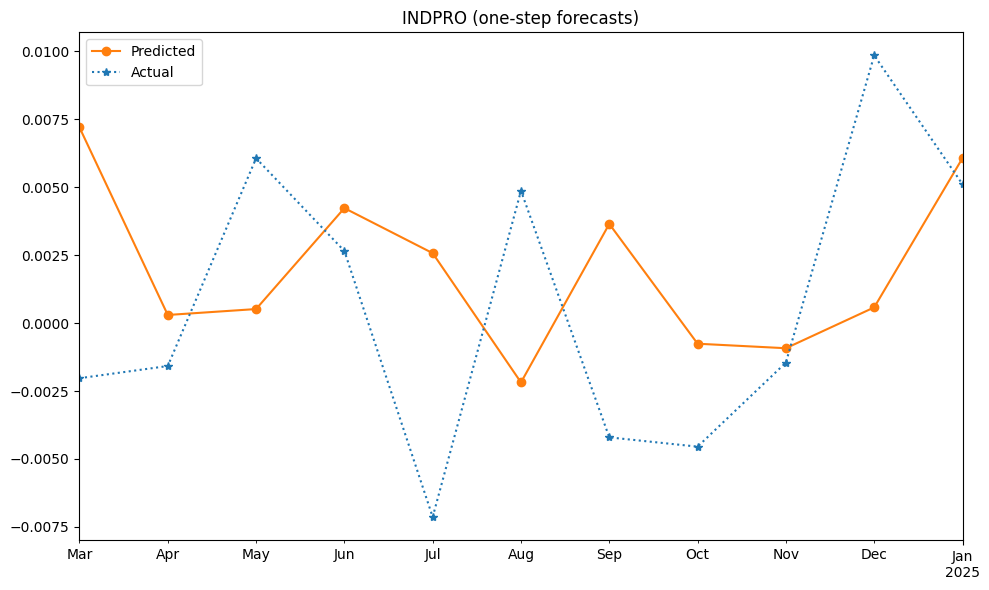

In [52]:
fig, ax = plt.subplots(clear=True, num=1, figsize=(10, 6))
df_pred.plot(ax=ax, c='C1', ls='-', marker='o', label='Predicted')
df_test.plot(ax=ax, c='C0', ls=':', marker='*', label='Actual')
ax.legend()
ax.set_title(series_id + " (one-step forecasts)")
ax.set_xlabel('')
plt.tight_layout()

### Multi-step forecast

**Multi-step forecasts** recursively predict values at future horizons, starting with $E_T[Y_{T+ 1}]. The forecast at horizon h depends on forecasts from earlier steps ($E_T[Y_{T+ 1}], ..., E_T [Y_{T+ h - 1}]). When these quantities appear in the forecast for period $T + h$, they are replaced by the forecasts computed for horizons $1, 2, ... , h - 1$.




Long-term Forecasts:  rmse=0.006085


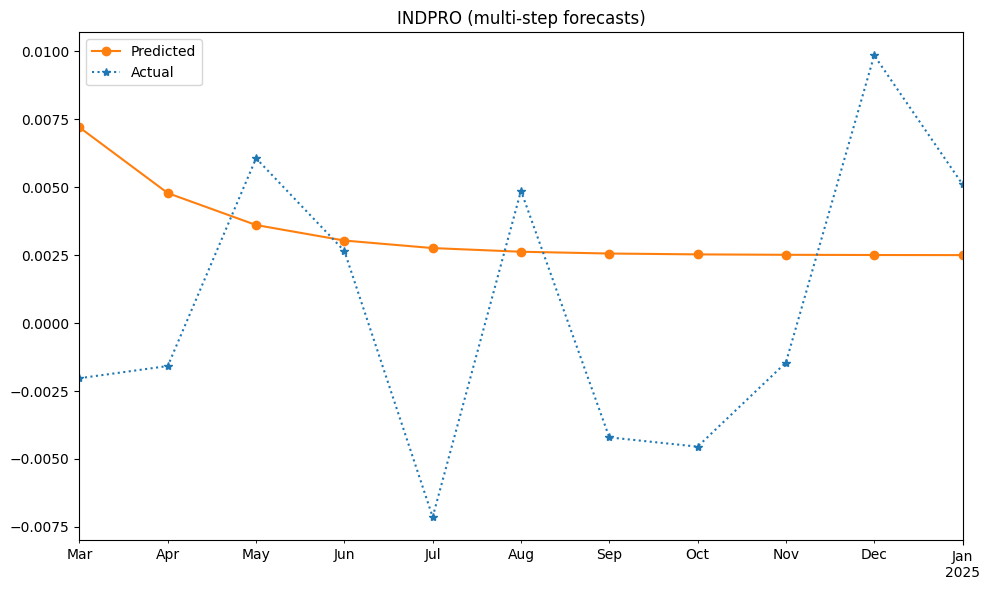

In [53]:
# set dynamic=True for multi-step ahead predictions
df_pred = test.predict(model.params, dynamic=True,
                       start=df_test.index[0], end=df_test.index[-1])
mse = mean_squared_error(df_test, df_pred)
#var = np.mean(np.square(df_test - df_train.mean()))
print(f"Long-term Forecasts:  rmse={np.sqrt(mse):.6f}")
fig, ax = plt.subplots(clear=True, num=2, figsize=(10, 6))
df_pred.plot(ax=ax, c='C1', ls='-', marker='o', label='Predicted')
df_test.plot(ax=ax, c='C0', ls=':', marker='*', label='Actual')
ax.legend()
ax.set_title(series_id + " (multi-step forecasts)")
ax.set_xlabel('')
plt.tight_layout()

### Granger causality

**Granger causality** tests whether past values of one time series help predict another. 

In [54]:
# Granger Causality: INDPRO vs CPI
variables = ['INDPRO', 'CPIAUCSL']
start = 19620101
for series_id, exog_id in zip(variables, list(reversed(variables))):
    df = pd.concat([alf(s, start=start, log=1)
                    for s in [series_id, exog_id]], axis=1)
    df.index = pd.DatetimeIndex(df.index.astype(str))
    df.index.freq = freq
    data = df.diff().dropna()

    print(f"Null Hypothesis: {exog_id} granger-causes {series_id}")
    res = grangercausalitytests(data, maxlag=3)
    print()

    dmf = (f'{series_id} ~ {series_id}.shift(1) '
           f' + {exog_id}.shift(1) '
           f' + {exog_id}.shift(2) '
           f' + {exog_id}.shift(3) ')
    model = smf.ols(formula=dmf, data=data).fit()
    robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
    print(robust.summary())

Null Hypothesis: CPIAUCSL granger-causes INDPRO

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4754  , p=0.4907  , df_denom=752, df_num=1
ssr based chi2 test:   chi2=0.4773  , p=0.4896  , df=1
likelihood ratio test: chi2=0.4772  , p=0.4897  , df=1
parameter F test:         F=0.4754  , p=0.4907  , df_denom=752, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1786  , p=0.0008  , df_denom=749, df_num=2
ssr based chi2 test:   chi2=14.4530 , p=0.0007  , df=2
likelihood ratio test: chi2=14.3162 , p=0.0008  , df=2
parameter F test:         F=7.1786  , p=0.0008  , df_denom=749, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4544  , p=0.0010  , df_denom=746, df_num=3
ssr based chi2 test:   chi2=16.5167 , p=0.0009  , df=3
likelihood ratio test: chi2=16.3381 , p=0.0010  , df=3
parameter F test:         F=5.4544  , p=0.0010  , df_denom=746, df_num=3

                            OLS Regression Re

### Impulse response function

**Impulse response functions (IRF)** analyze how shocks propagate through a system, often in **Vector Autoregression (VAR)** models.  

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Mar, 2025
Time:                     10:54:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.3411
Nobs:                     753.000    HQIC:                  -21.3939
Log likelihood:           5944.36    FPE:                4.94710e-10
AIC:                     -21.4270    Det(Omega_mle):     4.85639e-10
--------------------------------------------------------------------
Results for equation CPIAUCSL
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000909         0.000139            6.528           0.000
L1.CPIAUCSL         0.544275         0.036383           14.960           0.000
L1.INDPRO           0.004382         0.009861            0.444   

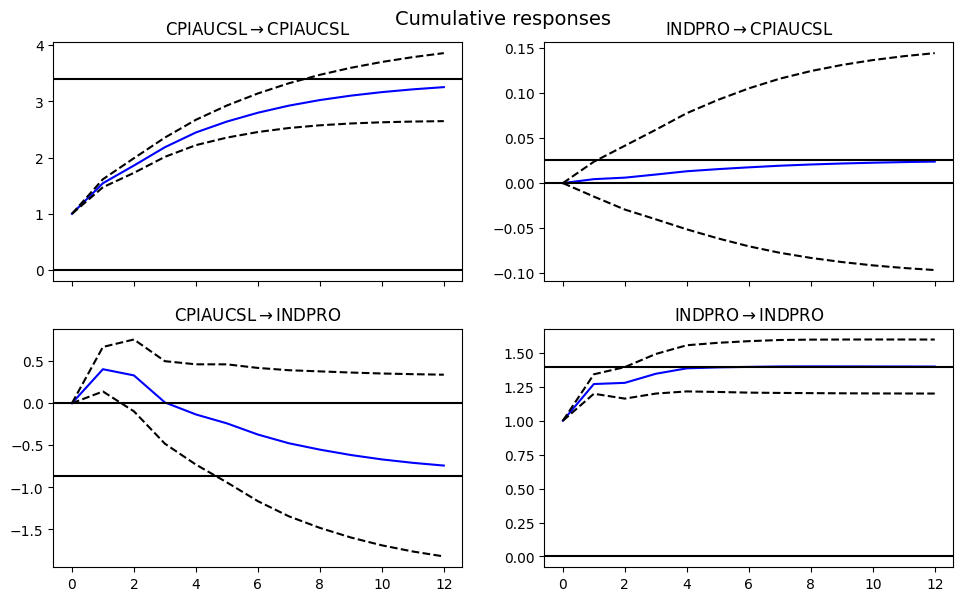

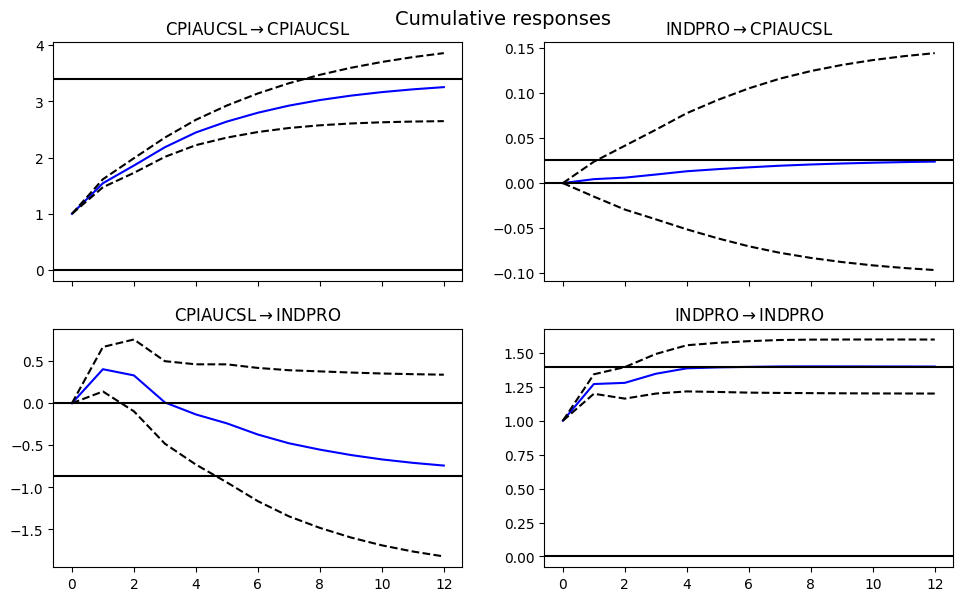

In [55]:
# Vector Autoregression: Impulse Response Function
model = VAR(data)
results = model.fit(maxlags=3)
print(results.summary())
irf = results.irf(12)
#irf.plot(orth=False)
irf.plot_cum_effects(orth=False, figsize=(10, 6))

__References:__

FRM Part I Exam Book Quantitative Analysis Ch 10-11